        2018     2019     2020     2021     2022
0     337485   686993  1284272  1244317  1285112
1    1030556  1920106   985410  1499299   805926
2    1030556  1598395   985410  1115398  1198180
3     697207  1621244   110652   213313  2054215
4    1464201   148152   985410  1020265  1198180
..       ...      ...      ...      ...      ...
361   125924   643626   985410  2648166  1669346
362  2477337   995967  3430383  1001102  1113987
363  1030556   392141   985410   966369   278274
364  1030556  1054901   134188   178873   416466
365   903441  1088381   985410  1001102  1218553

[366 rows x 5 columns]
366
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.76     -17.71*   1.927e-08     -17.74*
1       -17.76      -17.43   1.935e-08      -17.63
2       -17.75      -17.15   1.947e-08      -17.52
3      -17.78*      -16.90  1.901e-08*      -17.43
4       -17.75      -16.60 

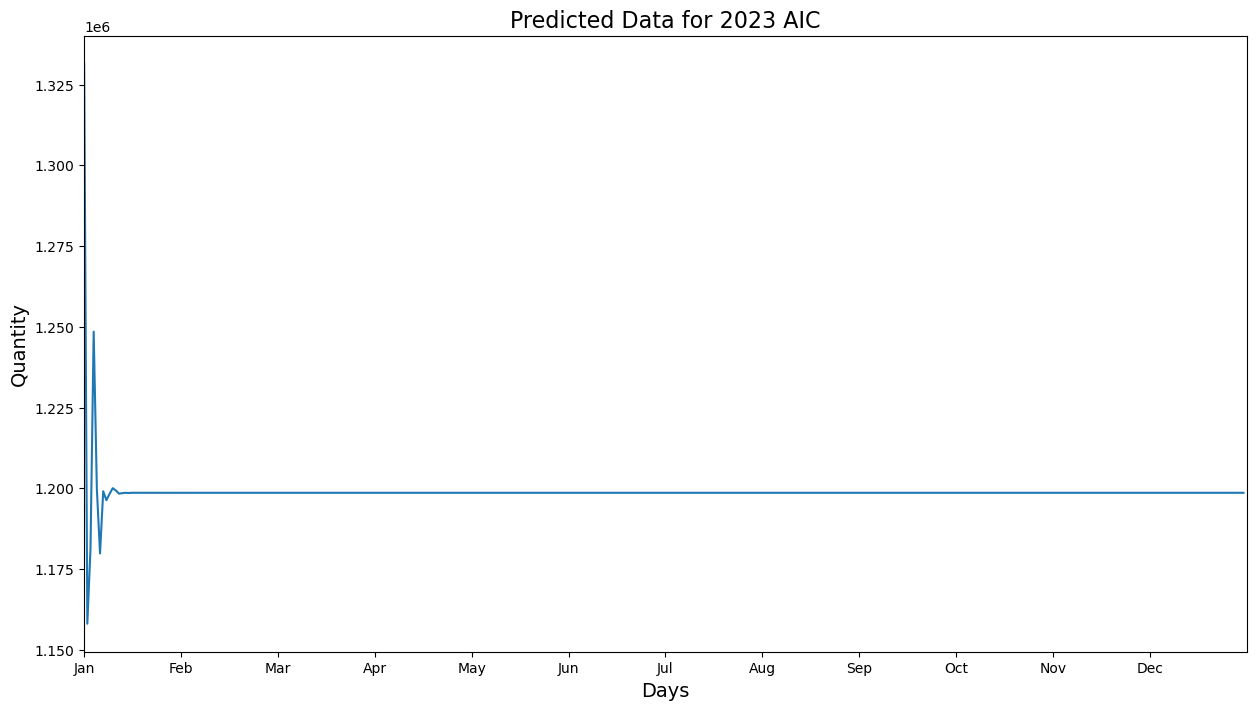

366


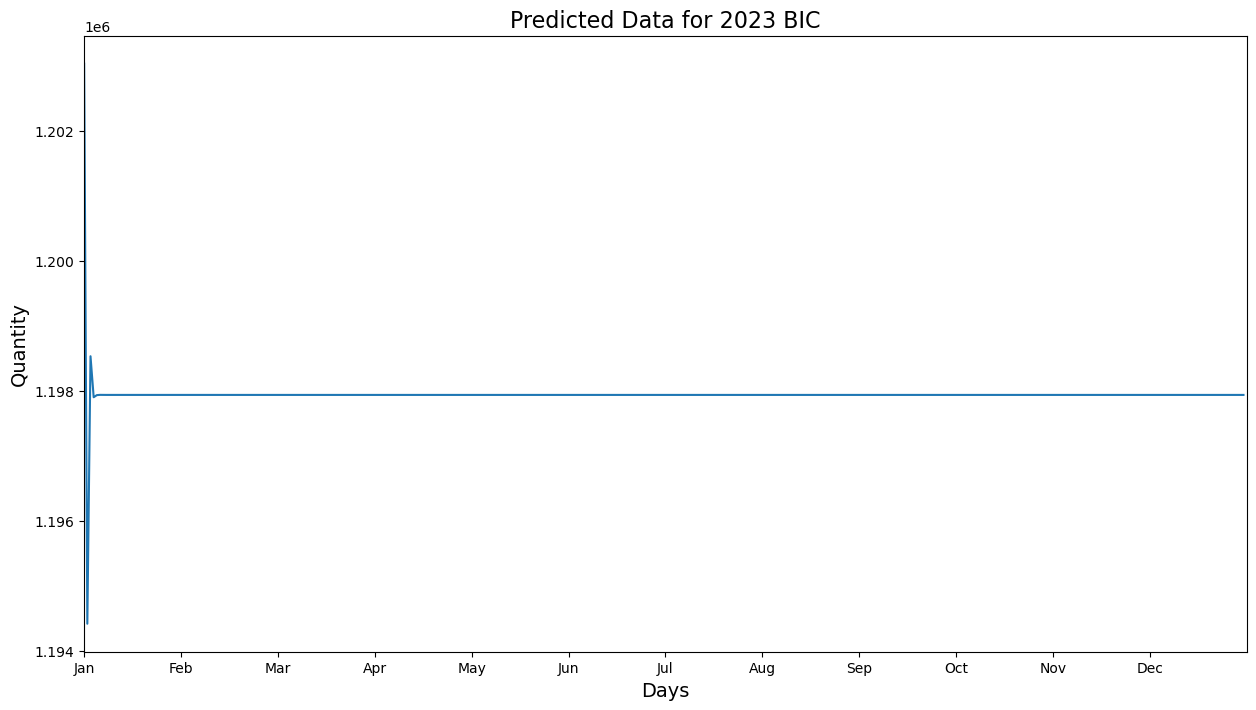

366


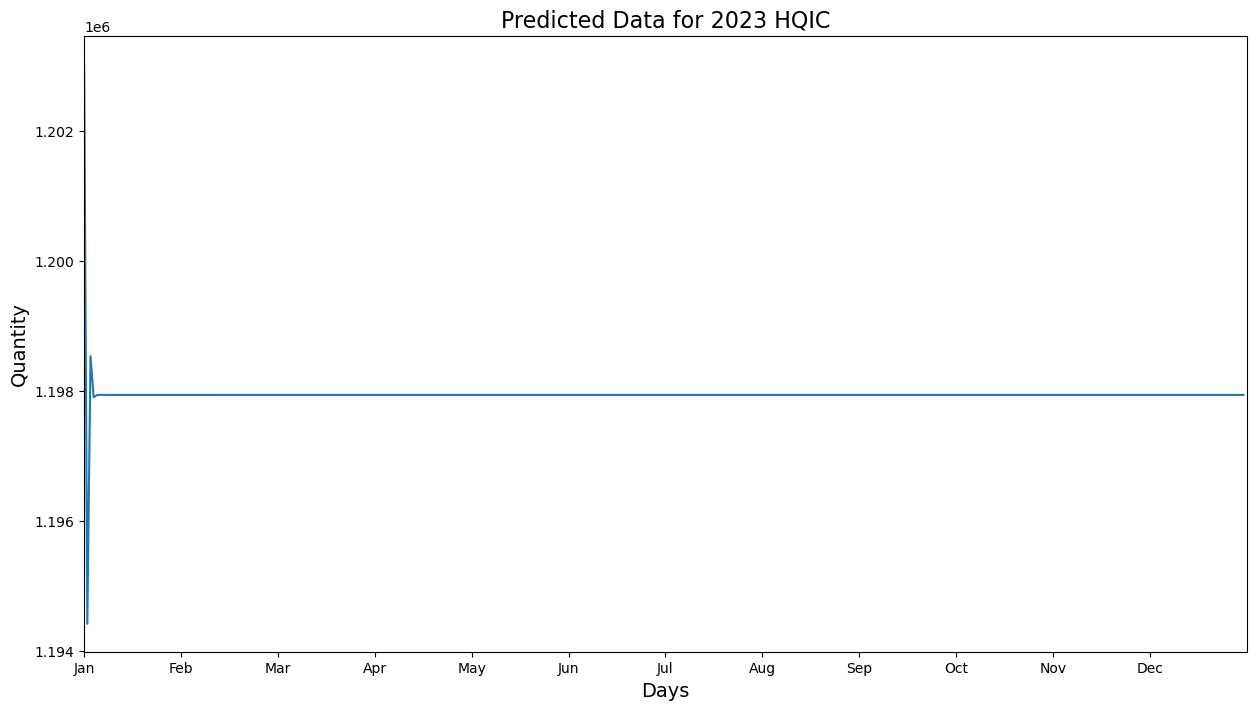

366


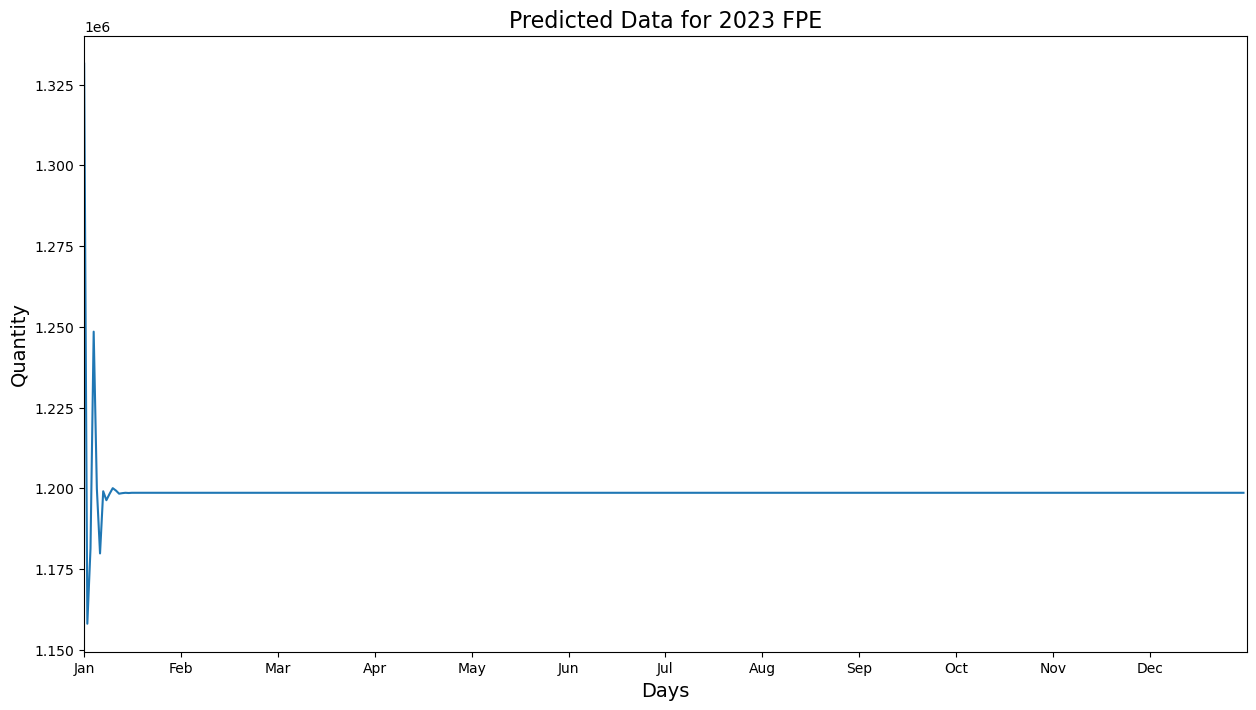

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

df = pd.read_csv(r"D:\NATPAC\Datasets\combined.csv")
df.drop(df.columns[0], axis=1, inplace=True)

print(df)
print(len(df))
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(df)

model = VAR(train_data_scaled)
order_selection = model.select_order(maxlags=12)
print(order_selection.summary())

optimal_lag_aic = order_selection.selected_orders['aic']
optimal_lag_bic = order_selection.selected_orders['bic']
optimal_lag_hqic = order_selection.selected_orders['hqic']
optimal_lag_fpe = order_selection.selected_orders['fpe']

print(f"Optimal lag order by AIC: {optimal_lag_aic}")
print(f"Optimal lag order by BIC: {optimal_lag_bic}")
print(f"Optimal lag order by HQIC: {optimal_lag_hqic}")
print(f"Optimal lag order by FPE: {optimal_lag_fpe}")

optimals = [optimal_lag_aic, 1, 1, optimal_lag_fpe]
optimalsname = ['AIC', 'BIC', 'HQIC', 'FPE']

forecast_horizon = 366

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_ticks = np.arange(0, 366, 30.5)
days = range(366)

for i in range(len(optimalsname)):
    model_fitted = VAR(train_data_scaled).fit(optimals[i])
    
    lagged_values = train_data_scaled[-model_fitted.k_ar:]
    
    forecasts = []
    forecast_2023 = []

    for _ in range(forecast_horizon):
        forecast_scaled = model_fitted.forecast(y=lagged_values, steps=1)
        forecast = scaler.inverse_transform(forecast_scaled)
        forecasts.append(forecast.flatten())

        lagged_values = np.vstack((lagged_values[1:], forecast_scaled))

        forecast_2023.extend(forecast[:, -1])

    print(len(forecast_2023))
    df2 = pd.read_csv(r"D:\NATPAC\Datasets\combined.csv")

    new_df = pd.DataFrame(forecast_2023, columns=["2023"])

    result_df = pd.concat([df2, new_df], axis=1)

    result_df.to_csv(r"D:\NATPAC\Datasets\VAR\2023_{}.csv".format(optimalsname[i]), index=False)

    plt.figure(figsize=(15, 8))
    plt.plot(days, forecast_2023, marker='')
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Quantity', fontsize=14)
    plt.title(f'Predicted Data for 2023 {optimalsname[i]}', fontsize=16)
    plt.xticks(month_ticks, months)
    plt.xlim(0, 366)
    plt.show()